In [1]:
### %reload_ext autoreload

%reset

import numpy as np

import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp


import pdb
import time

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk


#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af


%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
#For high Mmin
if (0):
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'highMmin')
    # Change minimum mass
    physics_settings['M_min'] = 1.0e3
#For low Mmin at true galactocentric distance
if (0):
    fft_type = 'fast'
    physics_type = 'baseline'
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = fft_type,\
                                                                     physics_type = physics_type)
    # get rid of M dependence for sigma
    physics_settings['lum_model'] = 'C0-simplified'
#For low Mmin at galactic center
if (1):
    fft_type = 'fast_isotropic'
    physics_type = 'isotropic'
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type =  fft_type, \
                                                                     physics_type = physics_type)
    # get rid of M dependence for sigma
    #physics_settings['lum_model'] = 'C0-simplified'
    

    
print(physics_settings)
print(fft_settings)

{'R_G': 220, 'd_sun': 0.001, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9, 'lum_model': 'C0-simplified', 'l_min': 0.001}
{'minF': 1e-16, 'maxF': 100000.0, 'numF': 8192, 'minlnk': -6.907755278982137, 'maxlnk': 15.424948470398375, 'numk': 8192, 'minf_out': 7e-05, 'maxf_out': 0.005, 'numf_out': 512, 'minf_pc': 7e-05, 'maxf_pc': 0.005}


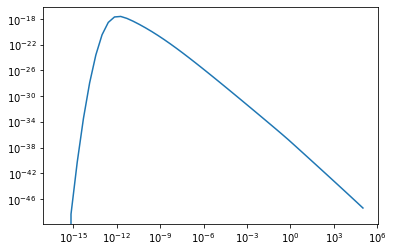

In [3]:
# Compute P_1(F)
#flux in photons/cm^2/yr
f_p1f = np.exp(np.linspace(np.log(1e-16), np.log(100000.0)))
p1f = subs.p_1_f(f_p1f, physics_settings, obs_settings)

fig, ax = pl.subplots(1,1)
ax.plot(f_p1f, p1f)
ax.set_xscale('log')
ax.set_yscale('log')

In [4]:
# Compute P(C) and P(F)

maxc = 100.
counts = np.arange(0,maxc)
pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                             obs_settings, return_fpf = True)

mu =  48294.378225636035


integral =  0.9782948706010367


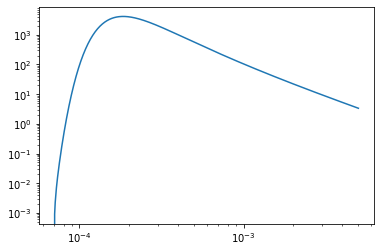

In [5]:
fig, ax = pl.subplots(1,1)
ax.plot(f_pf_precomputed, pf_pf_precomputed)
ax.set_xscale('log')
ax.set_yscale('log')

    
min_f = fft_settings['minf_out']
max_f = 4.0e-3 #fft_settings['maxf_out']

    
good = np.where((f_pf_precomputed > min_f) & (f_pf_precomputed < max_f))[0]
pf_good = pf_pf_precomputed[good]
f_good = f_pf_precomputed[good]
df_good = f_good[1:] - f_good[:-1]

check_integral = np.sum(0.5*df_good*(pf_good[1:] + pf_good[:-1]))
print("integral = ", check_integral)

integral =  0.9782948706010367


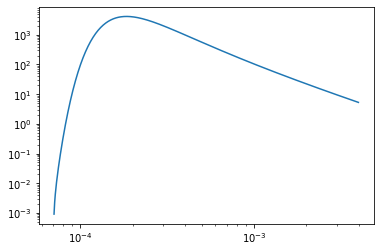

In [6]:
fig, ax = pl.subplots(1,1)
ax.plot(f_good, pf_good)
ax.set_xscale('log')
ax.set_yscale('log')
dfgood = f_good[1:] - f_good[:-1]
print("integral = ", np.sum(0.5*dfgood*(pf_good[1:] + pf_good[:-1])))

In [7]:
#Extend the pc
pc = subs.get_pc_fast(counts, f_good, pf_good, physics_settings, fft_settings, obs_settings, \
                 default_phipp = 1.0, do_extend = True)
    

sum pc =  0.9956783394891096


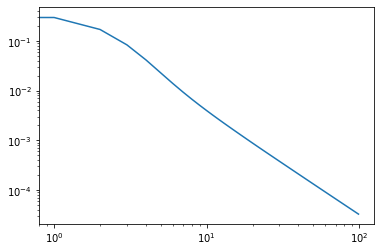

In [8]:
fig, ax = pl.subplots(1,1)
ax.plot(counts, pc)
ax.set_xscale('log')
ax.set_yscale('log')
print("sum pc = ", np.sum(pc))


In [9]:
save_pc = True
if save_pc:
    pf_data = {'maxc':maxc, 'pc':pc, 'counts':counts, 'f_pf_precomputed':f_pf_precomputed, \
               'pf_pf_precomputed':pf_pf_precomputed, \
               'f_p1f_cm2yr':f_p1f, 'p1f':p1f, \
               'physics_settings':physics_settings, 'fft_settings':fft_settings, 'obs_settings':obs_settings}
    pk.dump(pf_data, open('./data/Test_Data/pf_and_pc_for_test_Mmin' + str(physics_settings['M_min']) +\
                          '_phys' + physics_type + '_fft' + fft_type + \
                          '_withp1f_hires.pk','wb'))


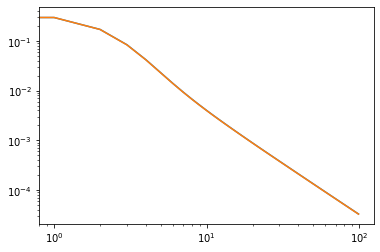

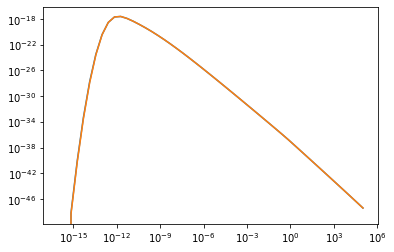

In [15]:
#compare res

file1 = 'pf_and_pc_for_test_Mmin1.0_physisotropic_fftfast_isotropic_withp1f.pk'
file2 = 'pf_and_pc_for_test_Mmin1.0_physisotropic_fftfast_isotropic_withp1f_hires.pk'

dat1 = pk.load(open('./data/Test_Data/' + file1, 'rb'))
dat2 = pk.load(open('./data/Test_Data/' + file2, 'rb'))


fig, ax = pl.subplots(1,1)
ax.plot(dat1['pc'])
ax.plot(dat2['pc'])
ax.set_yscale('log')
ax.set_xscale('log')


fig, ax = pl.subplots(1,1)
ax.plot(dat1['f_p1f_cm2yr'], dat1['p1f'])
ax.plot(dat2['f_p1f_cm2yr'], dat2['p1f'])
ax.set_yscale('log')
ax.set_xscale('log')